
### America's Next Top Model

In this module, I developed a framework for training multiple models easily with the intent of preventing overfitting. I first make a model pipeline that preprocesses data using standard scaling (b/c scikit learn models prefer normalized data). Then, I create a dictionary of model pipelines for organizational purposes. This would allow me to swap/add different models systematically. Next, I make hyperparameter grids for each model pipeline in order to again have a systematic way of swapping/adding different hyperparameters to tune. I then fit and tune models using 10 fold cross validation, with 20% of the observations used as a validation set. For this project I use 4 models: L1 logistic regression, L2 logistic regression, random forest classification, and a gradient boosted tree. 

Because this is a binary classification problem, I used ROC as my evaluation metric. 

Random Forest gave the best ROC score. I used the best_estimator method to get the best model parameters for the random forest model. I then saved the model at a .pkl file.  


In [1]:
# print_function for compatibility with Python 3
from __future__ import print_function
# NumPy for numerical computing
import numpy as np
# Pandas for DataFrames
import pandas as pd

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns
# Scikit-Learn for Modeling
import sklearn
# Pickle for saving model files
import pickle

In [2]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression
# Import RandomForestClassifier and GradientBoostingClassifer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [3]:
# Function for splitting training and test set
from sklearn.model_selection import train_test_split
# Function for creating model pipelines
from sklearn.pipeline import make_pipeline
# For standardization
from sklearn.preprocessing import StandardScaler
# Helper for cross-validation
from sklearn.model_selection import GridSearchCV
# Classification metrics (added later)
from sklearn.metrics import roc_curve, auc

In [5]:
# Load analytical base table from Module 2
df = pd.read_csv('analytical_base_table.csv')

<span id="split"></span>
# 1. Split the dataset

I split the data to have 20% of observation as a validation set. A subtlety is that I use stratified random sampling on the target variable in order to have the training and validation sets balanced. 

In [10]:
# Create separate object for target variable
y = df['status']

# Create separate object for input features
X = df.drop('status', axis=1)

In [12]:
# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=df.status)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

11254 2814 11254 2814


<span id="pipelines"></span>
# 2. Build model pipelines

I put my model pipelines in a dictionary for organizational purposes for when I fit and train the data using cross validation. 

In [29]:
# Pipeline dictionary
pipelines = {
    'l1': make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', random_state=123)),
    'l2': make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=123)),
    'rf': make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
    'gb': make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123))
}

<span id="hyperparameters"></span>
# 3. Declare hyperparameters to tune

I make a hyperparameter grid for each model I'd like to train. I then put these grids in a "hyperparameters" dictionary for organizational purposes. 

In [36]:
# List tuneable hyperparameters of our Logistic pipeline
pipelines['rf'].get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('randomforestclassifier',
   RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=None, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
               oob_score=False, random_state=123, verbose=0, warm_start=False))],
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'randomforestclassifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=

In [30]:
# Logistic Regression hyperparameters
l1_hyperparameters = {
    'logisticregression__C': np.linspace(1e-3, 1e3, 10)
}

l2_hyperparameters = {
    'logisticregression__C' : np.linspace(1e-3, 1e3, 10)
}

In [33]:
# Random Forest hyperparameters
rf_hyperparameters = {
    'randomforestclassifier__n_estimators':[100,200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33]
}

In [23]:
# Boosted Tree hyperparameters
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators':[100,200],
    'gradientboostingclassifier__learning_rate':[0.05,0.1,0.2],
    'gradientboostingclassifier__max_depth': [1,3,5]
}

In [34]:
# Create hyperparameters dictionary
hyperparameters = {
    'l1': l1_hyperparameters,
    'l2': l2_hyperparameters,
    'rf': rf_hyperparameters,
    'gb': gb_hyperparameters
}

<span id="fit-tune"></span>
# 4. Fit and tune models with cross-validation

This is the part where the existence of hyperparameters and model pipelines dictionaries comes into play. By making these dictionaries, I can make a for loop that iterates through the pipelines dictionaries, and inputs the hyperparameter grid and model pipeline for each model into its associated GridSearchCV object. This results in an elegant way to cross validate many model pipelines. 

In [35]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted')

c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


l1 has been fitted


c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


l2 has been fitted


c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


rf has been fitted


c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


gb has been fitted


<span id="evaluate"></span>
# 5. Evaluate metrics

In the previous for loop I create a dictionary of GridSearchCV objects. I can then iterate through the dictionary to print out the best score. Later, I use ROC b/c it's a better eval metric for binary classification. 

In [37]:
# Display best_score_ for each fitted model
for name, model in fitted_models.items():
    print(name, model.best_score_)

l1 0.8493868846632309
l2 0.8493868846632309
rf 0.979651679402879
gb 0.9752088146436823


<span id="auroc"></span>
# 6. Area under ROC curve

Here I practice making confusion matrices. Then, I get the ROC curves for each GridSearchCV object. Then I see which has the highest AUC and declare it the best model :O

In [38]:
# Classification metrics
from sklearn.metrics import roc_curve, auc

In [39]:
# Predict classes using L1-regularized logistic regression 
pred = fitted_models['l1'].predict(X_test)

# Display first 5 predictions
pred[:10]

c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0], dtype=int64)

In [40]:
# Import confusion_matrix
from sklearn.metrics import confusion_matrix

# Display confusion matrix for y_test and pred
print(confusion_matrix(y_test, pred))

[[1969  172]
 [ 221  452]]


In [41]:
# Predict PROBABILITIES using L1-regularized logistic regression
pred = fitted_models['l1'].predict_proba(X_test)

# Get just the prediction for the positive class (1)
pred = [p[1] for p in pred]

# Display first 5 predictions
pred[:10]

c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[0.030570398675690162,
 0.004442513021544129,
 0.007296468196970002,
 0.08809488966293264,
 0.0711503462848833,
 0.48161520731148844,
 0.12605157400968311,
 0.6152983084915888,
 0.7266609867522101,
 0.13703910193128782]

In [42]:
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_test, pred)

In [43]:
# Store fpr, tpr, thresholds in DataFrame and display last 10
pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Thresholds': thresholds}).tail(10)

,FPR,TPR,Thresholds
533,0.759925,0.994056,0.009628
534,0.784680,0.994056,0.008120
535,0.784680,0.995542,0.008077
536,0.910322,0.995542,0.001963
537,0.910322,0.997028,0.001950
538,0.932742,0.997028,0.001394
539,0.932742,0.998514,0.001388
540,0.949089,0.998514,0.001051
541,0.949089,1.000000,0.001040
542,1.000000,1.000000,0.000027


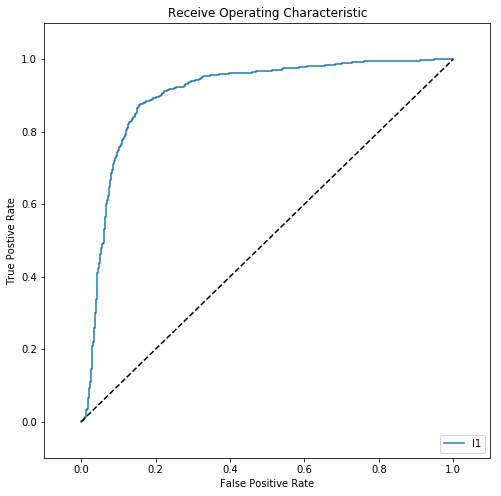

In [44]:
# Initialize figure
fig = plt.figure(figsize=(8,8))
plt.title('Receive Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc = 'lower right')

# Diagonal 45 degree line
plt.plot([0,1], [0,1], 'k--')

# Axes limits and labels
plt.xlim([-.1, 1.1])
plt.ylim([-.1, 1.1])
plt.ylabel('True Postive Rate')
plt.xlabel('False Positive Rate')
plt.show()


To calculate AUROC, use the <code style="color:steelblue">auc()</code> function we imported earlier in conjunction with the <code style="color:steelblue">roc_curve()</code> function.

In [45]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, pred)
# Calculate AUROC
print(auc(fpr, tpr))

0.9015395313878269


In [49]:
# Code here
for name, model in fitted_models.items():
    pred = fitted_models[name].predict_proba(X_test)
    pred = [p[1] for p in pred]
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    print(name, auc(fpr, tpr))

l1 0.9015395313878269
l2 0.9015388373737675
rf 0.9915194952019338
gb 0.9886802836851869


c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [46]:
y_test

9021     0
9838     0
8879     0
10454    0
8485     0
4833     0
8942     1
2209     1
6377     1
11958    0
10668    0
10650    0
13830    0
13056    0
6891     0
238      0
10368    0
10163    0
10082    0
4930     0
8911     0
12653    0
9961     0
6174     0
6245     0
9427     0
8917     0
3413     0
1129     0
7296     0
        ..
3360     0
13677    0
7164     0
3112     1
6388     0
721      1
5461     0
8236     0
12986    0
14025    0
5026     0
3938     0
3426     1
2024     1
11229    0
4657     0
4045     1
10817    1
2793     0
5808     0
190      0
835      0
5892     0
12818    0
9059     1
6538     0
10181    0
3148     0
6778     0
6936     1
Name: status, Length: 2814, dtype: int64

In [50]:
# Save winning model as final_model.pkl
with open('final_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)